In [1]:
import numpy as np
from PIL import Image


imageloc = 'images/plant.jpg'


image = Image.open(imageloc)
image = np.array(image.convert("RGB"))


# image = np.array(Image.open(imageloc).convert("RGB"))

h, w, _ = image.shape

# Define a center crop (e.g., central 20% of the image)
crop_size = 1
h0 = int(h * (0.5 - crop_size / 2))
h1 = int(h * (0.5 + crop_size / 2))
w0 = int(w * (0.5 - crop_size / 2))
w1 = int(w * (0.5 + crop_size / 2))

center_crop = image[h0:h1, w0:w1, :]



Auto-selected leaf point (HSV): [[np.int64(1512), np.int64(2016)]]


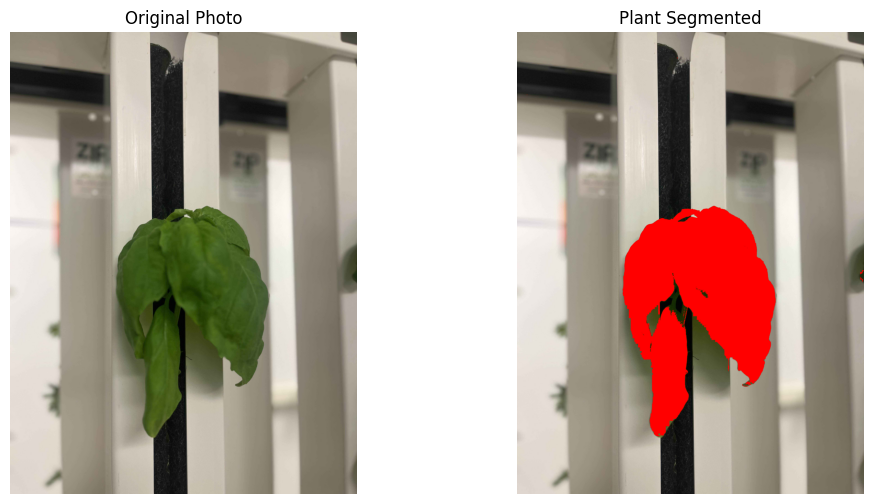

In [2]:
import cv2
center_crop_bgr = cv2.cvtColor(center_crop, cv2.COLOR_RGB2BGR)
hsv = cv2.cvtColor(center_crop_bgr, cv2.COLOR_BGR2HSV)
# Typical green range in HSV: 35-85
mask = (hsv[...,0] > 35) & (hsv[...,0] < 85) & (hsv[...,1] > 50) & (hsv[...,2] > 50)
candidates = np.argwhere(mask)
if candidates.shape[0]:
    center_y, center_x = np.array(mask.shape) // 2
    dists = np.sum((candidates - [center_y, center_x])**2, axis=1)
    chosen = candidates[np.argmin(dists)]
    y_rel, x_rel = chosen
    y_abs = y_rel + h0
    x_abs = x_rel + w0
    plantloc = [[x_abs, y_abs]]
    print("Auto-selected leaf point (HSV):", plantloc)
else:
    print("No green region found.")




import cv2
import matplotlib.pyplot as plt
import numpy as np

# If your crop is in RGB, convert to BGR for OpenCV, then to HSV
center_crop_bgr = cv2.cvtColor(center_crop, cv2.COLOR_RGB2BGR)
hsv = cv2.cvtColor(center_crop_bgr, cv2.COLOR_BGR2HSV)

# Define green range (tweak these values as needed)
mask = (hsv[...,0] > 35) & (hsv[...,0] < 85) & (hsv[...,1] > 50) & (hsv[...,2] > 50)

# Convert boolean mask to uint8 for visualization (0 or 255)
mask_img = (mask.astype(np.uint8)) * 255



# Overlay the mask (in red) on the original crop for visualization
overlay = center_crop.copy()
overlay[mask] = [255, 0, 0]  # Mark green areas as red for contrast

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(center_crop)
plt.title("Original Photo")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(overlay)
plt.title("Plant Segmented")
plt.axis('off')
plt.show()


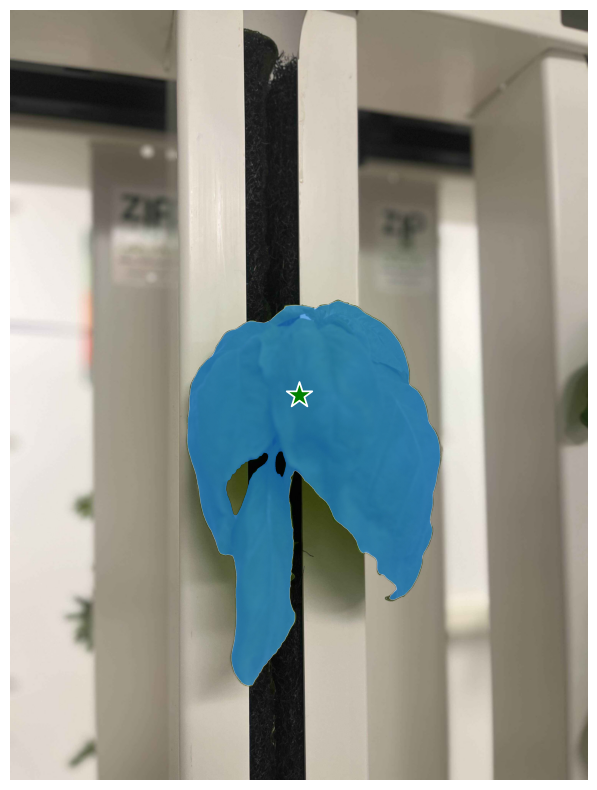

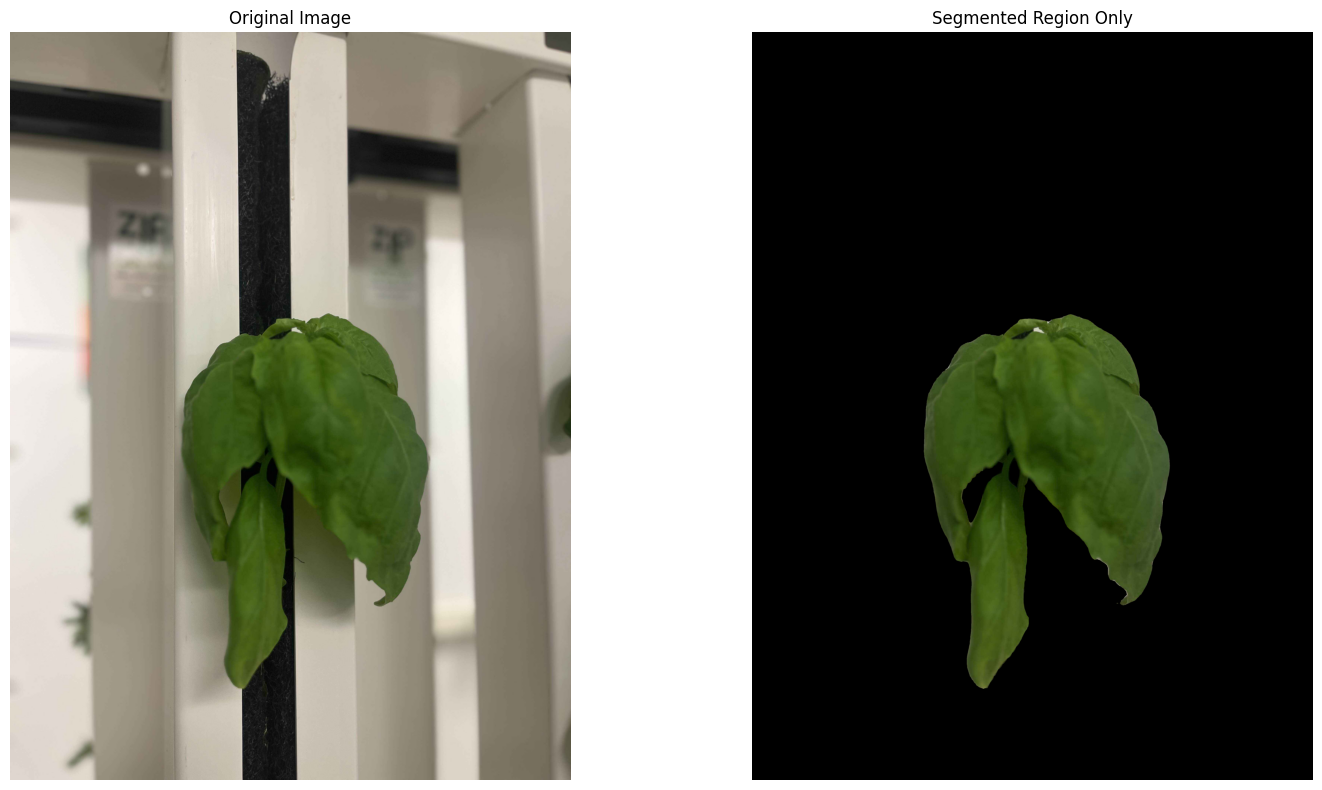

In [4]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt



#plantloc = [[1500, 2000]]

# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
#print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )



np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)

        # REMOVE IF NO POINT
        if point_coords is not None:
           assert input_labels is not None
           show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()





## start segmenting - import checkpoints
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"

#sam2_checkpoint = "../checkpoints/sam2.1_hiera_tiny.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
#model_cfg = "configs/sam2.1/sam2.1_hiera_t.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)
predictor.set_image(image)



input_point = np.array(plantloc)
input_label = np.array([1])




masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
best = np.argmax(scores)
masks = masks[best]
scores = scores[best]
logits = logits[best]



show_masks(image, [masks], [scores], point_coords=input_point, input_labels=input_label, borders=True)



binary_mask = masks.astype(bool)

segmented_image = np.zeros_like(image)
segmented_image[binary_mask] = image[binary_mask]

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

axs[0].imshow(image)
axs[0].set_title("Original Image")
axs[0].axis('off')

axs[1].imshow(segmented_image)
axs[1].set_title("Segmented Region Only")
axs[1].axis('off')

plt.tight_layout()
plt.show()

In [5]:
num_segmented_pixels = np.sum(binary_mask)
print("Number of pixels: ", num_segmented_pixels)

Number of pixels:  1548583
